Conclusions made for hyperparameters:

For mini-batch learning, having a larger batch size makes training faster, which is to be expected. Performance-wise, batch sizes 16 and 64 have similar performance, while 32 had slightly worse performance. Interestingly, batch sizes 16 and 64 have high noise in its loss graph, while batch size 32 has a more normal loss curve.

Metric-wise, all three optimizers perform about the same. The loss function history looks suspicious because of the extreme noise in the loss graph, but when we viewed the predicted outputs compared to the ground truth data, the predictions look fine. Between the optimizer's predictions, there is almost no visual difference. Out of all the loss graphs, relatively, SGD has the most normal loss graph.

Between the activation functions, their performance are also very similar, but tanh has slightly better MAE and RMSE, so we will keep that as our main activation function.

Other hyperparameter tuning conclusions: First layer having 64 nodes was best, second layer having 16 nodes was best, drop rate of 0.2 was just right (interestingly, drop rate 0.3 yielded very bad results), and having 15% data be validation was best (this can be because towards the end, there is more outliers, so reducing validation leads to outliers having more "weight").

Finally, we also found that using our custom weighted MSE, which scales loss up if the y truth is an outlier, improves our model.

(Final model training is towards end of notebook)
During training "improved" model, it turns out that combining changes does not improve model. Therefore, we will use the "base model", which happens to already have most of the optimal hyperparameters.


In [1]:
# using Recurrent Neural Network (LSTM)
# data preparation

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
import tensorflow as tf
import random

# fix random seed for replicability (added late)
random.seed(42)

# Load data
df = pd.read_csv('merged_data4.csv')
df.drop_duplicates(inplace=True)             # remove duplicate rows
df.dropna(inplace=True)                      # remove any rows with NaN
df = df.reset_index(drop=True)

# Date processing time (make cyclic via sin function)
df['Date'] = pd.to_datetime(df['Date'])
df['day_of_week'] = np.sin(2 * np.pi / 7.0 * df['Date'].dt.dayofweek )
df['hour_of_day'] = np.sin(2 * np.pi / 24.0 * df['Date'].dt.hour)
df['month'] = np.sin(2 * np.pi / 12.0 * (df['Date'].dt.month - 1))

# Additional features and target (to help better predict outlier data)
df['AvgPrice_Other_sq'] = df['AveragePrice_OtherStates'] ** 2
df['AvgPrice_Other_3h'] = df['AveragePrice_OtherStates'].diff(periods=3)
# fill the NaN values created at the beginning
df.fillna(0, inplace=True)

features = [
    'forecasted_load',
    'actual_load',
    'day_ahead_lmp',
    'AveragePrice_OtherStates',
    'AvgPrice_Other_sq',
    'AvgPrice_Other_3h',
    'day_of_week',
    'hour_of_day',
    'month',
    'wind_speed_kmh',
    # the following are coco weather reports (0 or 1) -> used AI to generate automatically
    'coco_Clear',
    'coco_Fair',
    'coco_Cloudy',
    'coco_Overcast',
    'coco_Fog',
    'coco_Light_Rain',
    'coco_Rain',
    'coco_Heavy_Rain',
    'coco_Heavy_Rain_Shower',
    'coco_Light_Snow',
    'coco_Snow',
    'coco_Heavy_Snow',
    'coco_Thunderstorm',
    'coco_Sleet',
    'coco_Heavy_Sleet'
]
target = 'actual_lmp'

X = df[features].values
y = df[target].values.reshape(-1, 1)

# Normalize data (important for RNNs)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Define sequence length (how many past steps you want to use)
seq_len = 7  # using past 24 hours - originally 168

# Create time series sequences
X_seq, y_seq = [], []
for i in range(seq_len, len(X_scaled)):
    X_seq.append(X_scaled[i - seq_len:i])
    y_seq.append(y_scaled[i])

X_seq, y_seq = np.array(X_seq), np.array(y_seq)

# Split into train/evaluation (train will be further split to train and validation)
split = int(0.85 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

FileNotFoundError: [Errno 2] No such file or directory: 'merged_data4.csv'

In [5]:
# Some useful functions to look at results of model

# Plots graph of loss for train+test per epoch (prob only use for significant experiments cuz it takes up space)
# Used AI to help know how to use history
def plot_history(history):
  history_dict = history.history
  loss_values = history_dict['loss']
  val_loss_values = history_dict['val_loss']
  epochs = range(1, len(loss_values) + 1)

  plt.plot(epochs, loss_values, 'g', label='Training Loss')
  plt.plot(epochs, val_loss_values, 'b', label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

# Print eval metrics of model
def print_evaluation(Model):
  # Predictions
  y_pred_scaled = Model.predict(X_test)
  y_pred = scaler_y.inverse_transform(y_pred_scaled)
  y_true = scaler_y.inverse_transform(y_test)

  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = np.sqrt(mse)
  r2 = r2_score(y_true, y_pred)

  print(f"MAE = {mae:.3f}")
  print(f"MSE = {mse:.3f}")
  print(f"RMSE = {rmse:.3f}")
  print(f"R² = {r2:.3f}")

# Experiment on model's hyper-parameters
def simplify_model_change(l1=64, l2=32, drop=0.2, activation='tanh', split=0.15, num_epochs=20):
  model = Sequential([
      LSTM(l1, activation=activation, return_sequences=True, input_shape=(seq_len, X_seq.shape[2])),
      Dropout(drop),
      LSTM(l2, activation=activation),
      Dropout(drop),
      Dense(1)
  ])
  model.compile(optimizer='adam', loss='mse')
  history_relu = model.fit(X_train, y_train,epochs=num_epochs,batch_size=32,validation_split=split)

  # print eval here cuz why not
  print_evaluation(model)

# Used AI to create plot
def plot_prediction_vs_actual(Model):
  # 1. Get the corresponding dates for the test set
  # The test data starts after the sequence length and the training split
  test_dates = df['Date'][split + seq_len:].reset_index(drop=True)

  y_pred_scaled = Model.predict(X_test)
  y_pred = scaler_y.inverse_transform(y_pred_scaled)
  y_true = scaler_y.inverse_transform(y_test)

  y_pred = y_pred.flatten()
  y_true = y_true.flatten()

  # Ensure the lengths match before plotting
  if len(test_dates) != len(y_true):
      print(f"Warning: Length of dates ({len(test_dates)}) does not match length of test data ({len(y_true)}). Plot may be incorrect.")

  # 2. Create the first plot: Actual vs. Predicted
  plt.figure(figsize=(20, 8))
  plt.plot(test_dates, y_true, color='blue', label='Actual Prices')
  plt.plot(test_dates, y_pred, color='red', alpha=0.8, linestyle='--', label='Predicted Prices')
  plt.title('Model Performance: Actual vs. Predicted LMP', fontsize=16)
  plt.xlabel('Date', fontsize=12)
  plt.ylabel('LMP Price', fontsize=12)
  plt.legend()
  plt.grid(True)
  plt.show()

  # 3. Create the second plot: Prediction Error (Difference)
  error = y_true - y_pred

  plt.figure(figsize=(20, 8))
  plt.plot(test_dates, error, color='green', label='Prediction Error (Actual - Predicted)')
  plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
  plt.title('Prediction Error Over Time', fontsize=16)
  plt.xlabel('Date', fontsize=12)
  plt.ylabel('Error', fontsize=12)
  plt.legend()
  plt.grid(True)
  plt.show()

In [3]:
# Used AI to help program "custom loss" function (to penalize conservative behavior of model)
def weighted_mse(y_true, y_pred):
    # ~4.86% of labeled data are "outliers" (via IQR method)
    # also want to include values close to outliers s
    spike_threshold = 0.90

    weights = K.cast(K.greater(y_true, spike_threshold), 'float32') * 9.0 + 1.0
    return K.mean(weights * K.square(y_true - y_pred))

In [4]:
# TRAIN BASE MODEL (in which we will modify a single parameter at a time, so
# every other parameter is the same as the base's -> easier to make comparisons

model = Sequential([
    LSTM(64, activation='tanh', return_sequences=True, input_shape=(seq_len, X_seq.shape[2])),
    Dropout(0.2),
    LSTM(32, activation='tanh'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

# Train model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.15,
    verbose=1
)

print_evaluation(model)
# Base model's eval performance
# MAE = 11.123
# MSE = 643.213
# RMSE = 25.362
# R² = 0.246

NameError: name 'seq_len' is not defined

In [ ]:
# Experiment on batch size (16 and 64, base = 32)
history_batch16 = model.fit(X_train, y_train,epochs=20,batch_size=16,validation_split=0.15)
print_evaluation(model)
# MAE = 10.484
# MSE = 645.561
# RMSE = 25.408
# R² = 0.243


history_batch64 = model.fit(X_train, y_train,epochs=20,batch_size=64,validation_split=0.15)
print_evaluation(model)
# MAE = 10.349
# MSE = 621.420
# RMSE = 24.928
# R² = 0.271

Epoch 1/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 1.9046e-04 - val_loss: 2.0874e-04
Epoch 2/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 1.9727e-04 - val_loss: 1.9787e-04
Epoch 3/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 1.8528e-04 - val_loss: 2.2728e-04
Epoch 4/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 1.9616e-04 - val_loss: 1.9382e-04
Epoch 5/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 2.1539e-04 - val_loss: 1.9408e-04
Epoch 6/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 2.9920e-04 - val_loss: 2.0166e-04
Epoch 7/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 2.9087e-04 - val_loss: 1.9562e-04
Epoch 8/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 2.1960e-04 - val_loss: 1.8967e-04
Epoch 9/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 2.2389e-04 - val_loss: 2.4188e-04
Epoch 10/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 1.9011e-04 - val_loss: 2.1239e-04
Epoch 11/20
1129/1129 ━━━━━━━━━━━━━━━

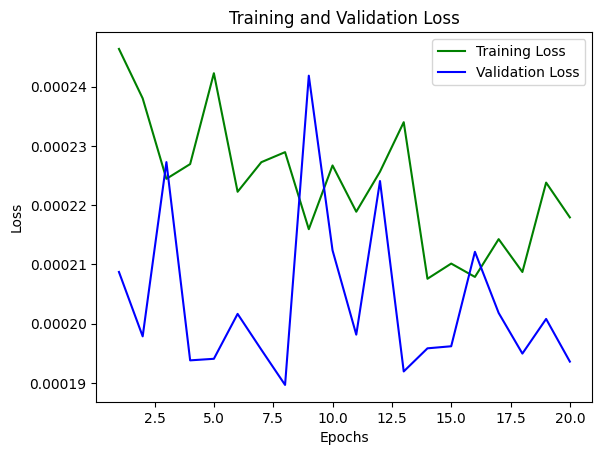

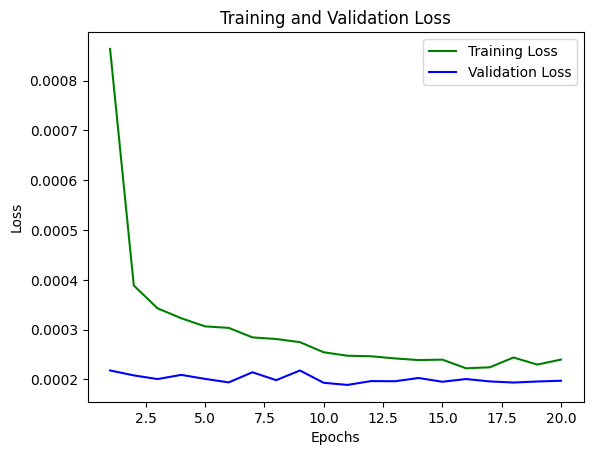

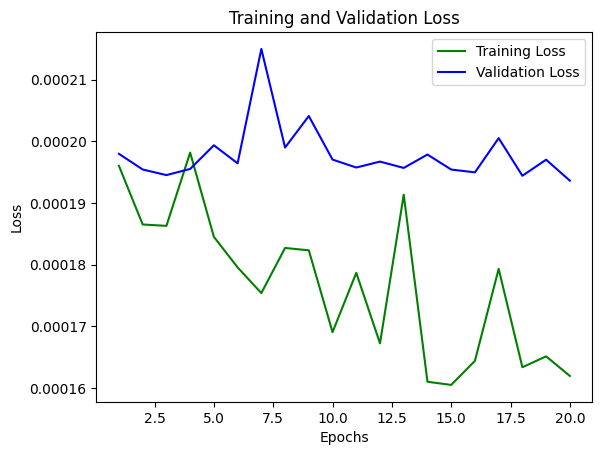

In [ ]:
plot_history(history_batch16)
plot_history(history)
plot_history(history_batch64)

In [ ]:
# Experiment on optimizer (adam, sgd, rmsprop) + learning rate (1e-3, 1e-4)
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')
history_adam3 = model.fit(X_train, y_train,epochs=20,batch_size=32,validation_split=0.15,verbose=1)
print_evaluation(model)
# MAE = 12.106
# MSE = 644.272
# RMSE = 25.383
# R² = 0.244

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')
history_adam4 = model.fit(X_train, y_train,epochs=20,batch_size=32,validation_split=0.15)
print_evaluation(model)
# MAE = 10.962
# MSE = 632.765
# RMSE = 25.155
# R² = 0.258

# use default recommended momentum value (= 0.9)
model.compile(optimizer=SGD(learning_rate=1e-3, momentum=0.9), loss='mse')
history_sgd3 = model.fit(X_train, y_train,epochs=20,batch_size=32,validation_split=0.15)
print_evaluation(model)
# MAE = 10.593
# MSE = 630.743
# RMSE = 25.115
# R² = 0.260

model.compile(optimizer=SGD(learning_rate=1e-4, momentum=0.9), loss='mse')
history_sgd4 = model.fit(X_train, y_train,epochs=20,batch_size=32,validation_split=0.2)
print_evaluation(model)
# MAE = 10.789
# MSE = 631.473
# RMSE = 25.129
# R² = 0.259

model.compile(optimizer=RMSprop(learning_rate=1e-3), loss='mse')
history_rmsp3 = model.fit(X_train, y_train,epochs=20,batch_size=32,validation_split=0.15)
print_evaluation(model)
# MAE = 11.356
# MSE = 637.009
# RMSE = 25.239
# R² = 0.253

model.compile(optimizer=RMSprop(learning_rate=1e-4), loss='mse')
history_rmsp4 = model.fit(X_train, y_train,epochs=20,batch_size=32,validation_split=0.15)
print_evaluation(model)
# MAE = 10.360
# MSE = 630.255
# RMSE = 25.105
# R² = 0.261

Epoch 1/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 1.8881e-04 - val_loss: 1.9917e-04
Epoch 2/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.5893e-04 - val_loss: 1.9524e-04
Epoch 3/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 1.7697e-04 - val_loss: 1.9296e-04
Epoch 4/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.5587e-04 - val_loss: 1.9509e-04
Epoch 5/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.5002e-04 - val_loss: 1.9888e-04
Epoch 6/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.9474e-04 - val_loss: 1.9728e-04
Epoch 7/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 1.5789e-04 - val_loss: 1.9507e-04
Epoch 8/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.4971e-04 - val_loss: 1.9434e-04
Epoch 9/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 1.6177e-04 - val_loss: 1.9815e-04
Epoch 10/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.9811e-04 - val_loss: 2.0903e-04
Epoch 11/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss

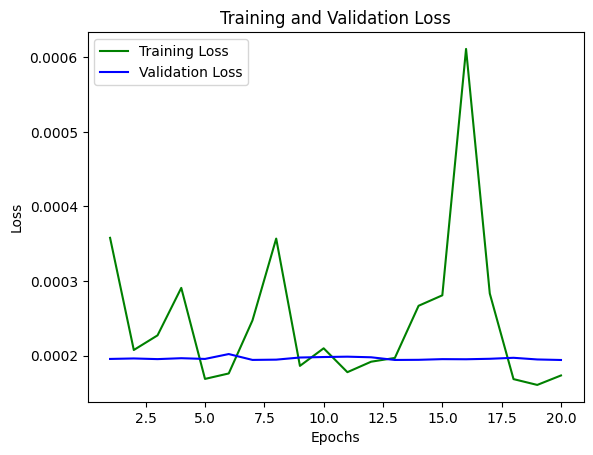

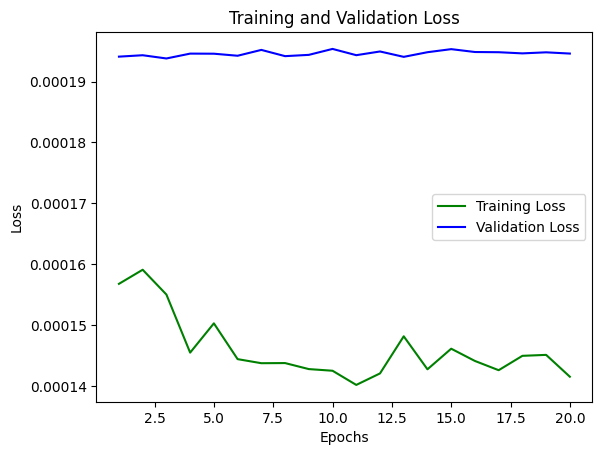

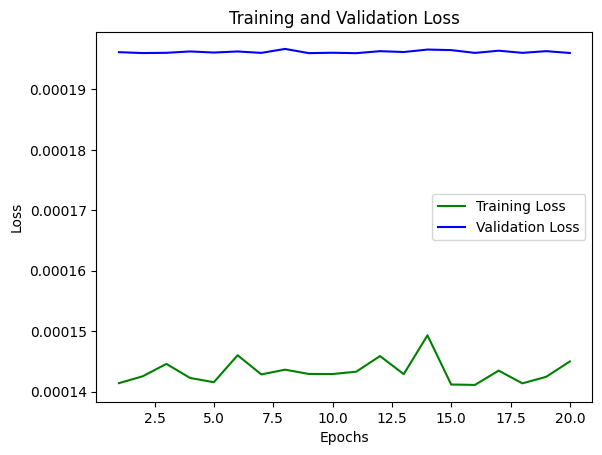

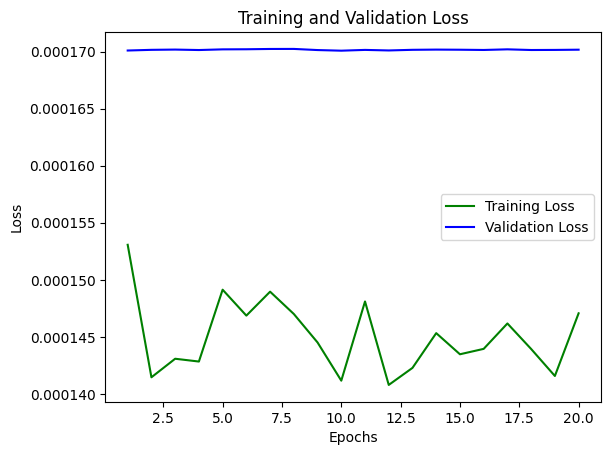

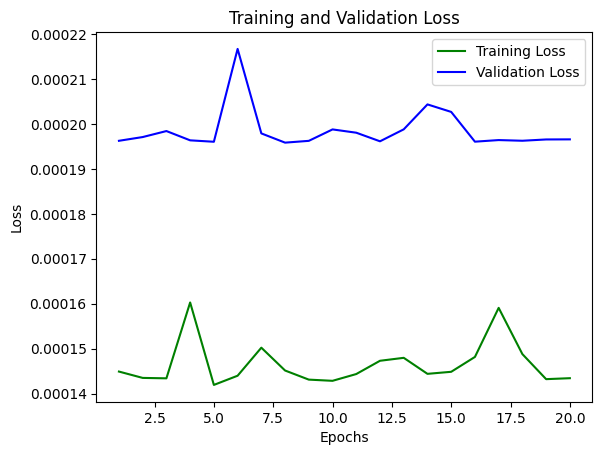

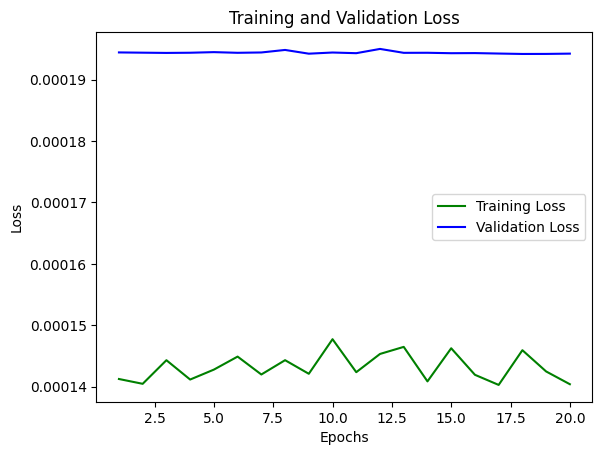

In [ ]:
plot_history(history_adam3)
plot_history(history_adam4)
plot_history(history_sgd3)
plot_history(history_sgd4)
plot_history(history_rmsp3)
plot_history(history_rmsp4)

Epoch 1/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 1.6691e-04 - val_loss: 1.9461e-04
Epoch 2/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 1.3699e-04 - val_loss: 1.9498e-04
Epoch 3/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 1.4178e-04 - val_loss: 1.9442e-04
Epoch 4/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.2919e-04 - val_loss: 1.9483e-04
Epoch 5/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 1.6980e-04 - val_loss: 1.9455e-04
Epoch 6/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 1.2800e-04 - val_loss: 1.9456e-04
Epoch 7/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.1833e-04 - val_loss: 1.9464e-04
Epoch 8/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 1.2783e-04 - val_loss: 1.9513e-04
Epoch 9/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 1.5289e-04 - val_loss: 1.9492e-04
Epoch 10/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 1.4732e-04 - val_loss: 1.9467e-04
Epoch 11/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss

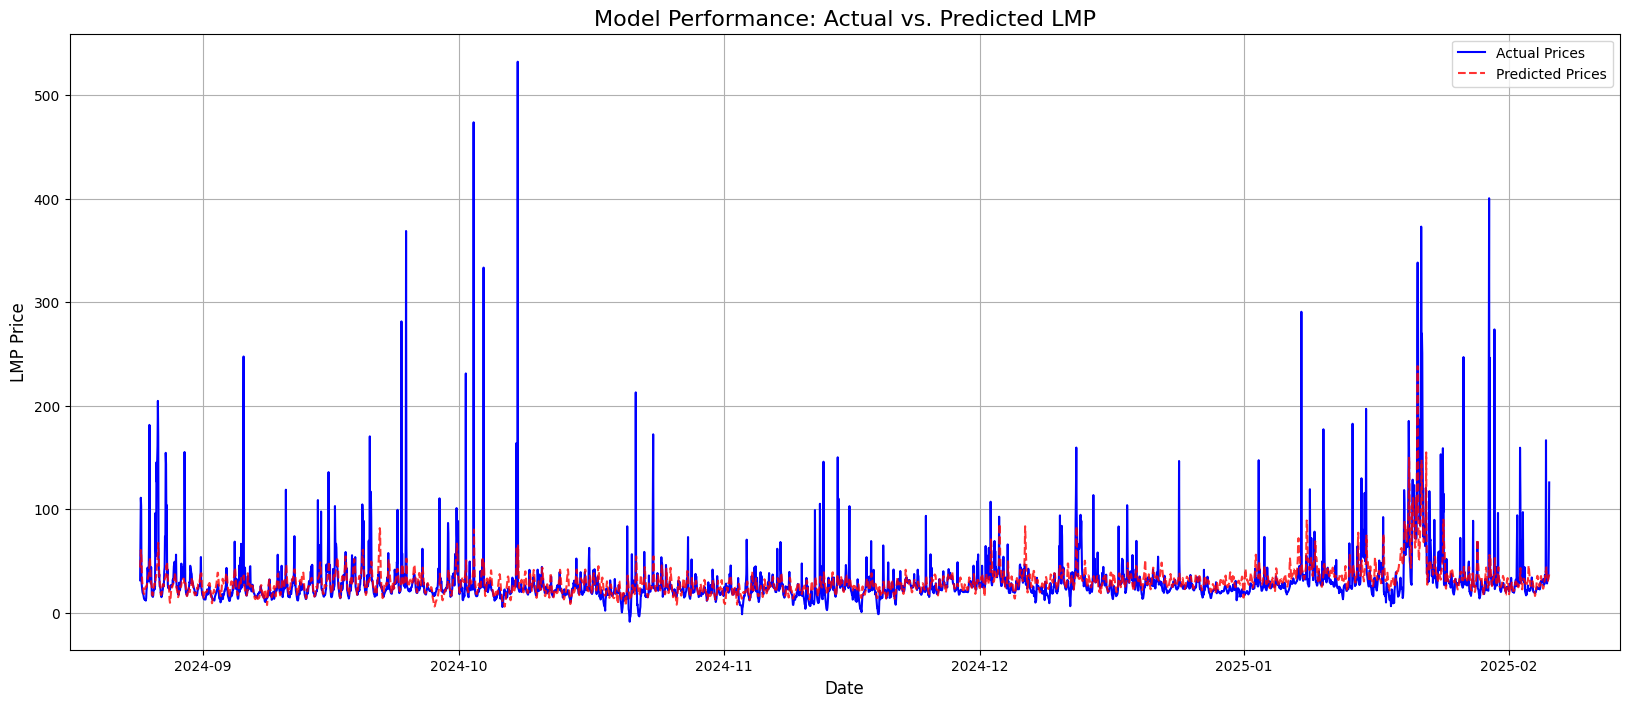

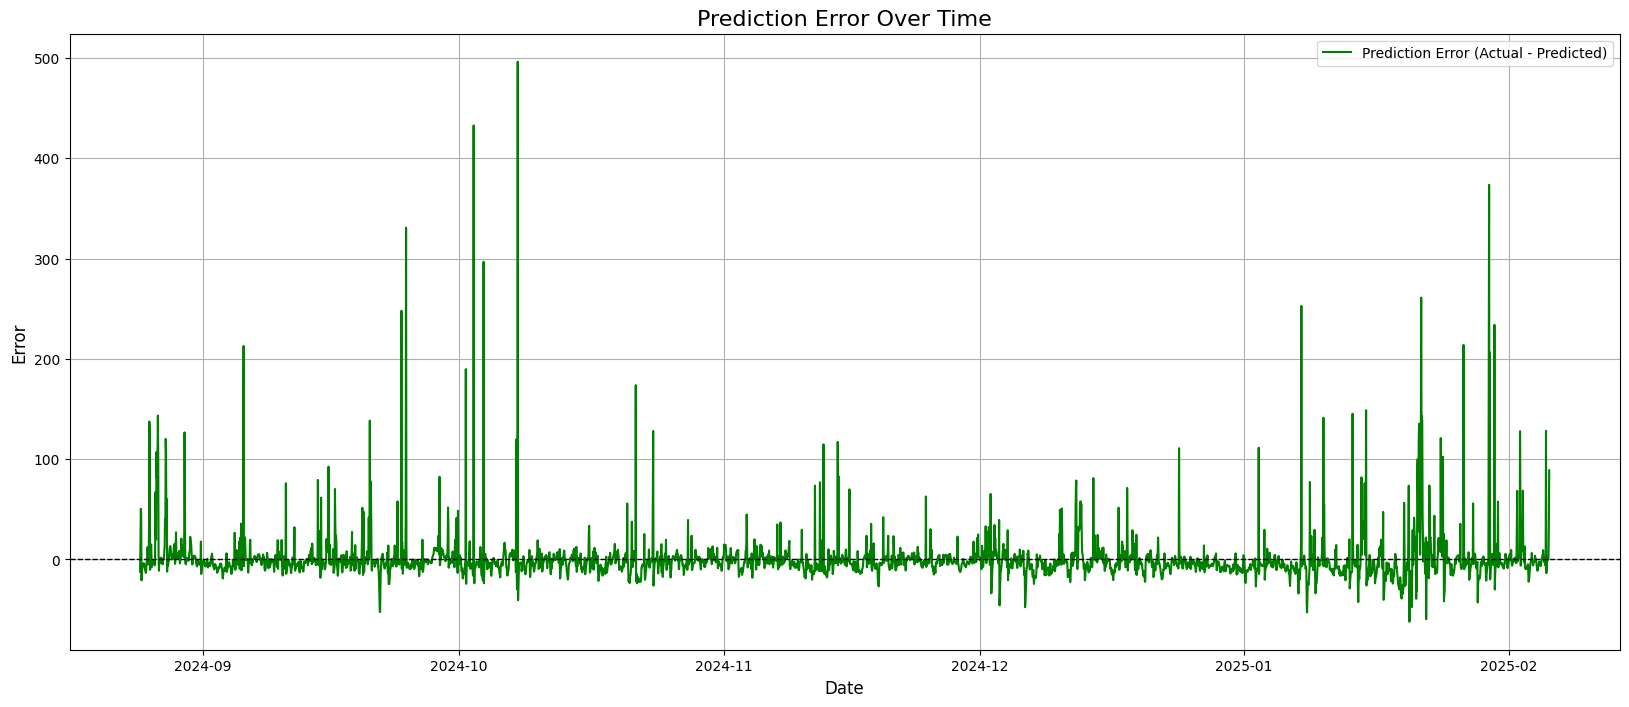

Epoch 1/20
532/532 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 1.5359e-04 - val_loss: 1.7032e-04
Epoch 2/20
532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.2973e-04 - val_loss: 1.7046e-04
Epoch 3/20
532/532 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 1.3015e-04 - val_loss: 1.7054e-04
Epoch 4/20
532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.5764e-04 - val_loss: 1.7049e-04
Epoch 5/20
532/532 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 1.2398e-04 - val_loss: 1.7052e-04
Epoch 6/20
532/532 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 1.5807e-04 - val_loss: 1.7056e-04
Epoch 7/20
532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.3965e-04 - val_loss: 1.7053e-04
Epoch 8/20
532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.4326e-04 - val_loss: 1.7048e-04
Epoch 9/20
532/532 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 1.2512e-04 - val_loss: 1.7058e-04
Epoch 10/20
532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.2609e-04 - val_loss: 1.7059e-04
Epoch 11/20
532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss

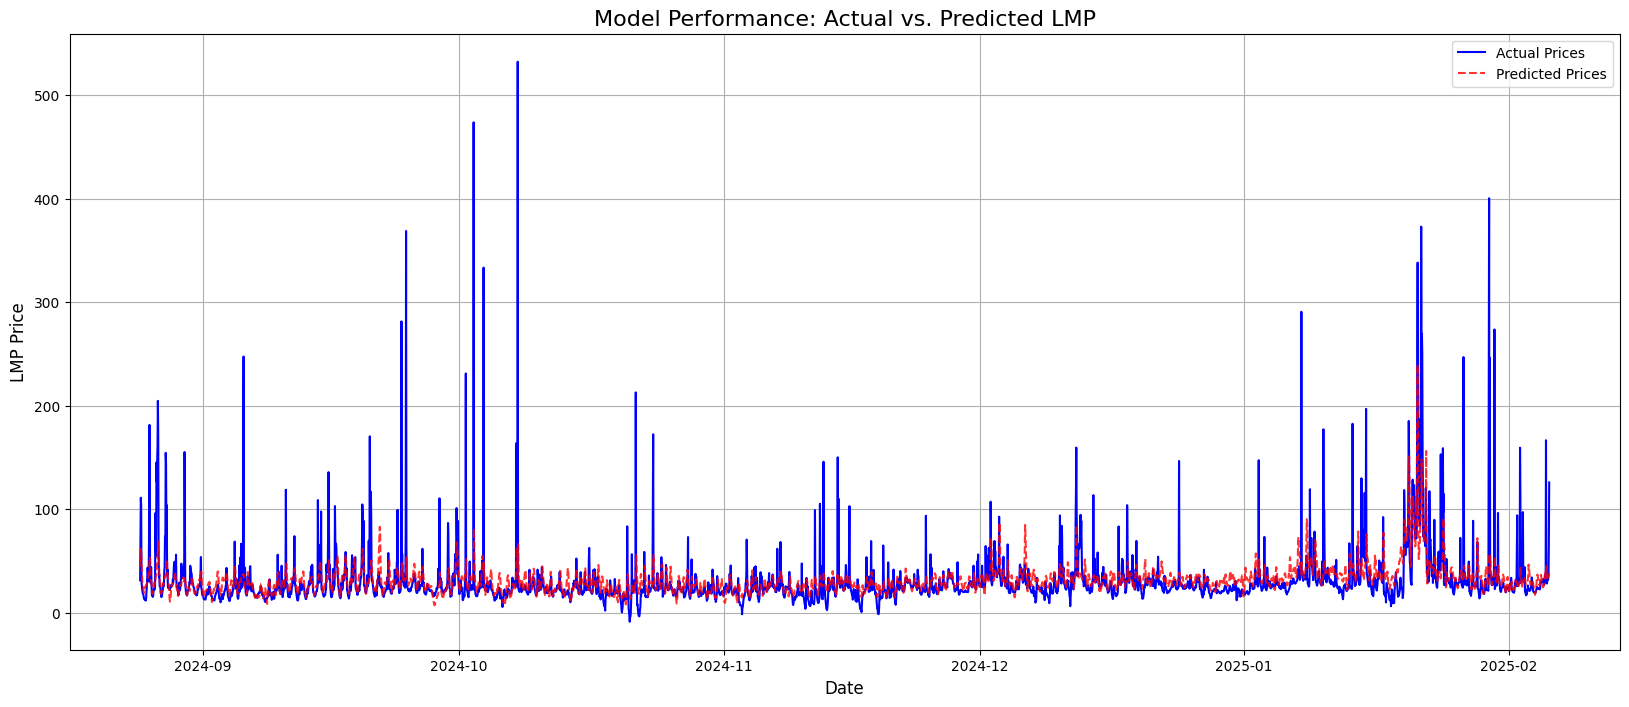

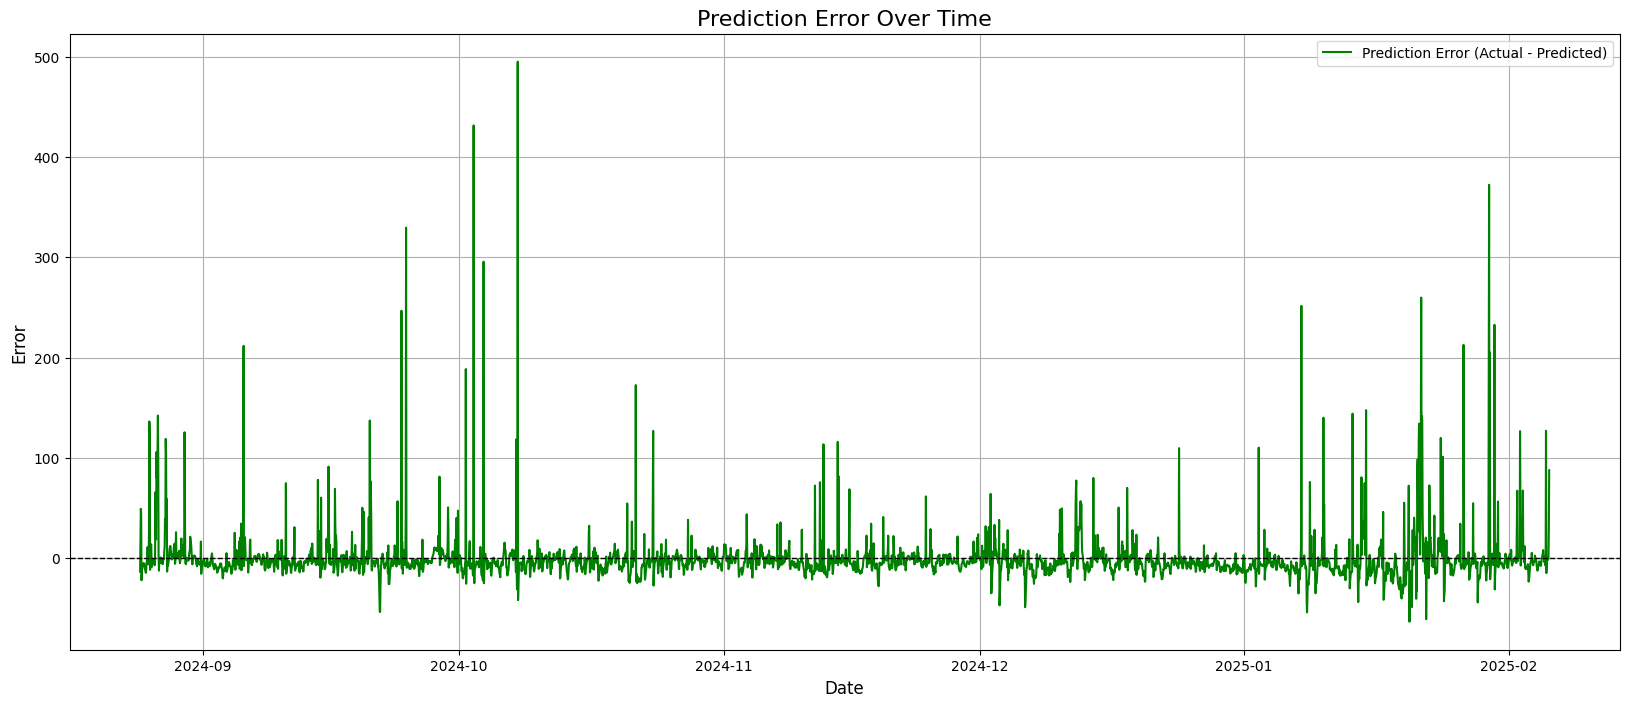

Epoch 1/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 1.2187e-04 - val_loss: 1.9499e-04
Epoch 2/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 1.2286e-04 - val_loss: 1.9568e-04
Epoch 3/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 1.4559e-04 - val_loss: 1.9513e-04
Epoch 4/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 1.3297e-04 - val_loss: 1.9489e-04
Epoch 5/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 1.2827e-04 - val_loss: 1.9474e-04
Epoch 6/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 1.4763e-04 - val_loss: 1.9491e-04
Epoch 7/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.4508e-04 - val_loss: 1.9482e-04
Epoch 8/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 1.4595e-04 - val_loss: 1.9563e-04
Epoch 9/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 1.4349e-04 - val_loss: 1.9476e-04
Epoch 10/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 1.3630e-04 - val_loss: 1.9474e-04
Epoch 11/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss

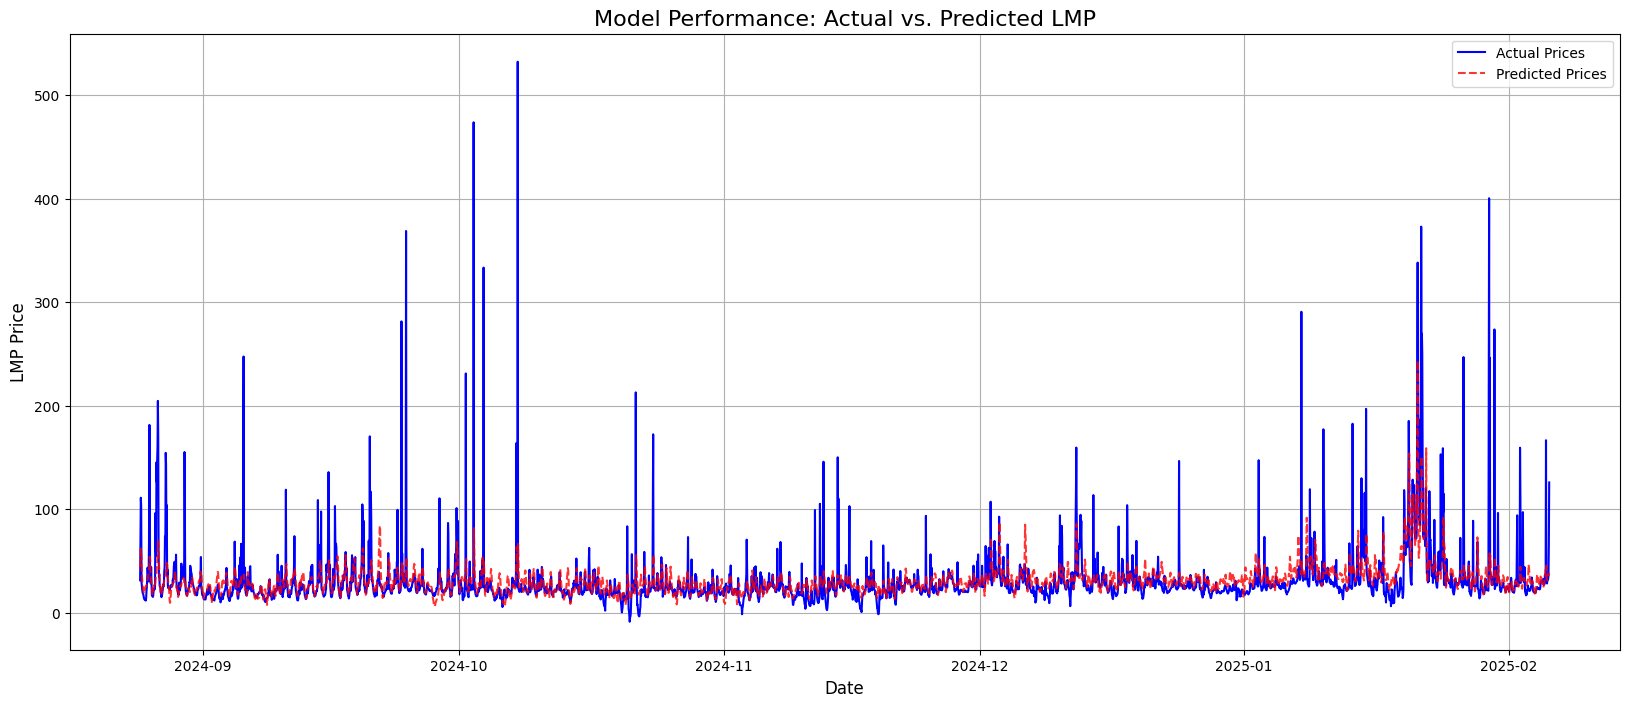

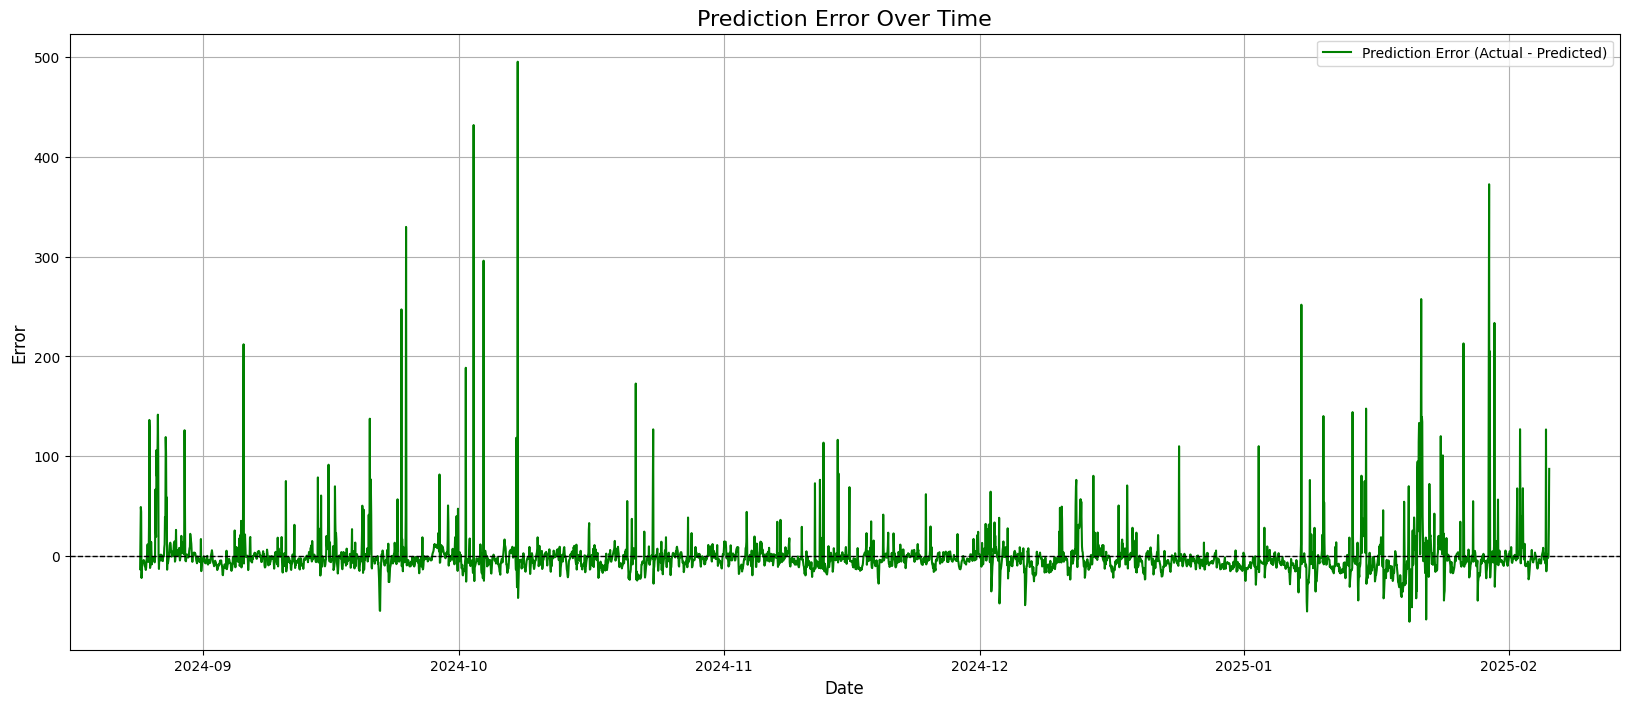

In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')
history_adam4 = model.fit(X_train, y_train,epochs=20,batch_size=32,validation_split=0.15)
plot_prediction_vs_actual(model)

model.compile(optimizer=SGD(learning_rate=1e-4, momentum=0.9), loss='mse')
history_sgd4 = model.fit(X_train, y_train,epochs=20,batch_size=32,validation_split=0.2)
plot_prediction_vs_actual(model)

model.compile(optimizer=RMSprop(learning_rate=1e-4), loss='mse')
history_rmsp4 = model.fit(X_train, y_train,epochs=20,batch_size=32,validation_split=0.15)
plot_prediction_vs_actual(model)

In [ ]:
## Activation (relu, sigmoid) for each layer
simplify_model_change(activation='relu')
# MAE = 11.245
# MSE = 689.336
# RMSE = 26.255
# R² = 0.192

simplify_model_change(activation='sigmoid')
# MAE = 11.409
# MSE = 729.304
# RMSE = 27.006
# R² = 0.145

## Number of nodes on layers (layer 1 = [32, 64, 128], layer 2 = [16, 32])
simplify_model_change(l1=32)
# MAE = 14.312
# MSE = 675.712
# RMSE = 25.994
# R² = 0.207
simplify_model_change(l1=128)
# MAE = 14.103
# MSE = 789.783
# RMSE = 28.103
# R² = 0.074
simplify_model_change(l2=16)
# MAE = 10.647
# MSE = 641.130
# RMSE = 25.321
# R² = 0.248
simplify_model_change(l1=28, l2=32)
# MAE = 11.308
# MSE = 636.999
# RMSE = 25.239
# R² = 0.253

## Dropout rate (0.1, 0.3)
simplify_model_change(drop=0.1)
# MAE = 13.105
# MSE = 666.110
# RMSE = 25.809
# R² = 0.219
simplify_model_change(drop=0.3)
# MAE = 18.583
# MSE = 842.317
# RMSE = 29.023
# R² = 0.012

## Num epochs (10, 30)
simplify_model_change(num_epochs=10)
# MAE = 13.040
# MSE = 749.844
# RMSE = 27.383
# R² = 0.121
simplify_model_change(num_epochs=30)
# MAE = 13.327
# MSE = 670.616
# RMSE = 25.896
# R² = 0.213
## Split ratio (0.1, 0.3)
simplify_model_change(split=0.1)
# MAE = 19.299
# MSE = 806.171
# RMSE = 28.393
# R² = 0.054
simplify_model_change(split=0.3)
# MAE = 14.056
# MSE = 715.961
# RMSE = 26.757
# R² = 0.160

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0018 - val_loss: 2.1520e-04
Epoch 2/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 4.0511e-04 - val_loss: 2.1667e-04
Epoch 3/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.9712e-04 - val_loss: 2.0226e-04
Epoch 4/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 3.0933e-04 - val_loss: 2.0591e-04
Epoch 5/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 4.0627e-04 - val_loss: 2.0901e-04
Epoch 6/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.2084e-04 - val_loss: 2.2070e-04
Epoch 7/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 3.3721e-04 - val_loss: 2.0679e-04
Epoch 8/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.2602e-04 - val_loss: 2.1147e-04
Epoch 9/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.7185e-04 - val_loss: 2.0434e-04
Epoch 10/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.6882e-04 - val_loss: 2.0313e-04
Epoch 11/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.9576e-04 - 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0219 - val_loss: 2.4256e-04
Epoch 2/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 7.7494e-04 - val_loss: 2.6682e-04
Epoch 3/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 5.4505e-04 - val_loss: 2.3197e-04
Epoch 4/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 6.1904e-04 - val_loss: 2.3733e-04
Epoch 5/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 3.7723e-04 - val_loss: 2.7283e-04
Epoch 6/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 3.4733e-04 - val_loss: 2.7868e-04
Epoch 7/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 3.9875e-04 - val_loss: 2.6452e-04
Epoch 8/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 3.7690e-04 - val_loss: 3.4920e-04
Epoch 9/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 4.1537e-04 - val_loss: 2.5408e-04
Epoch 10/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 3.6314e-04 - val_loss: 2.5485e-04
Epoch 11/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 3.8302e-04 - 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0015 - val_loss: 2.1573e-04
Epoch 2/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.8306e-04 - val_loss: 2.1228e-04
Epoch 3/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 3.1026e-04 - val_loss: 1.9799e-04
Epoch 4/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.7727e-04 - val_loss: 2.0188e-04
Epoch 5/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.4423e-04 - val_loss: 1.9932e-04
Epoch 6/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 3.0594e-04 - val_loss: 2.0041e-04
Epoch 7/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.3443e-04 - val_loss: 2.0594e-04
Epoch 8/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 3.6058e-04 - val_loss: 2.0996e-04
Epoch 9/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.7377e-04 - val_loss: 2.0227e-04
Epoch 10/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.8246e-04 - val_loss: 2.5964e-04
Epoch 11/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 3.7540e-04 - 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


565/565 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0019 - val_loss: 2.4726e-04
Epoch 2/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 3.8396e-04 - val_loss: 2.7898e-04
Epoch 3/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 3.4384e-04 - val_loss: 2.0594e-04
Epoch 4/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 3.5151e-04 - val_loss: 2.0046e-04
Epoch 5/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 3.0276e-04 - val_loss: 2.0131e-04
Epoch 6/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 3.0969e-04 - val_loss: 1.9641e-04
Epoch 7/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 2.6880e-04 - val_loss: 2.1270e-04
Epoch 8/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 2.4752e-04 - val_loss: 1.9998e-04
Epoch 9/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 2.2515e-04 - val_loss: 2.1801e-04
Epoch 10/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 3.5250e-04 - val_loss: 1.9871e-04
Epoch 11/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 2.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0017 - val_loss: 2.1218e-04
Epoch 2/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 3.9523e-04 - val_loss: 2.0191e-04
Epoch 3/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 4.2791e-04 - val_loss: 2.4691e-04
Epoch 4/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.8035e-04 - val_loss: 2.0028e-04
Epoch 5/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 2.8039e-04 - val_loss: 2.0135e-04
Epoch 6/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.4537e-04 - val_loss: 2.0711e-04
Epoch 7/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 3.1360e-04 - val_loss: 1.9873e-04
Epoch 8/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.1802e-04 - val_loss: 1.9612e-04
Epoch 9/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.5679e-04 - val_loss: 2.0164e-04
Epoch 10/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 2.2613e-04 - val_loss: 1.9807e-04
Epoch 11/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.2262e-04 - 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0016 - val_loss: 2.0375e-04
Epoch 2/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 4.9931e-04 - val_loss: 2.2395e-04
Epoch 3/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 3.7576e-04 - val_loss: 2.1097e-04
Epoch 4/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.5826e-04 - val_loss: 2.0753e-04
Epoch 5/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.4062e-04 - val_loss: 2.0957e-04
Epoch 6/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.5932e-04 - val_loss: 2.0635e-04
Epoch 7/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.7572e-04 - val_loss: 2.0623e-04
Epoch 8/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.2714e-04 - val_loss: 2.0128e-04
Epoch 9/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.7953e-04 - val_loss: 2.0274e-04
Epoch 10/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.8206e-04 - val_loss: 1.9287e-04
Epoch 11/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 2.1410e-04 - 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0012 - val_loss: 2.1310e-04
Epoch 2/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 3.3078e-04 - val_loss: 2.1583e-04
Epoch 3/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 3.1771e-04 - val_loss: 2.3780e-04
Epoch 4/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 4.1830e-04 - val_loss: 2.1477e-04
Epoch 5/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.0864e-04 - val_loss: 2.0721e-04
Epoch 6/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.2385e-04 - val_loss: 1.9776e-04
Epoch 7/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.4725e-04 - val_loss: 2.0871e-04
Epoch 8/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 2.0441e-04 - val_loss: 3.1081e-04
Epoch 9/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.4210e-04 - val_loss: 2.0004e-04
Epoch 10/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.4061e-04 - val_loss: 1.9561e-04
Epoch 11/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.6506e-04 - 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0021 - val_loss: 2.0347e-04
Epoch 2/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 3.8197e-04 - val_loss: 2.0666e-04
Epoch 3/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 3.4149e-04 - val_loss: 2.0288e-04
Epoch 4/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 4.1912e-04 - val_loss: 1.9972e-04
Epoch 5/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.7356e-04 - val_loss: 2.1182e-04
Epoch 6/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.4930e-04 - val_loss: 2.0889e-04
Epoch 7/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 2.4914e-04 - val_loss: 1.9926e-04
Epoch 8/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 2.7629e-04 - val_loss: 2.7393e-04
Epoch 9/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.8174e-04 - val_loss: 2.1362e-04
Epoch 10/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 2.9497e-04 - val_loss: 1.9634e-04
Epoch 11/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.8877e-04 - 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0015 - val_loss: 1.9782e-04
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 3.4821e-04 - val_loss: 2.0710e-04
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 3.2520e-04 - val_loss: 2.5820e-04
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 3.5371e-04 - val_loss: 2.1011e-04
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.3463e-04 - val_loss: 2.0234e-04
Epoch 6/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 3.3690e-04 - val_loss: 2.0779e-04
Epoch 7/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 2.2934e-04 - val_loss: 2.0653e-04
Epoch 8/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 2.5029e-04 - val_loss: 1.9989e-04
Epoch 9/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.9847e-04 - val_loss: 2.0247e-04
Epoch 10/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 4.7242e-04 - val_loss: 2.0570e-04
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
MAE = 13.040
MSE = 749.844
RMSE =

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0018 - val_loss: 2.3231e-04
Epoch 2/30
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 3.5025e-04 - val_loss: 2.0741e-04
Epoch 3/30
565/565 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 5.0542e-04 - val_loss: 2.0307e-04
Epoch 4/30
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 4.0476e-04 - val_loss: 2.7113e-04
Epoch 5/30
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.9497e-04 - val_loss: 2.0611e-04
Epoch 6/30
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 2.4544e-04 - val_loss: 2.1261e-04
Epoch 7/30
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 5.4211e-04 - val_loss: 1.9340e-04
Epoch 8/30
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.9183e-04 - val_loss: 2.0818e-04
Epoch 9/30
565/565 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 4.1056e-04 - val_loss: 2.2661e-04
Epoch 10/30
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.7953e-04 - val_loss: 1.9358e-04
Epoch 11/30
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 2.8950e-04 - 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


598/598 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0012 - val_loss: 2.2712e-04
Epoch 2/20
598/598 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 4.1445e-04 - val_loss: 2.2359e-04
Epoch 3/20
598/598 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 3.0854e-04 - val_loss: 2.7480e-04
Epoch 4/20
598/598 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 2.1311e-04 - val_loss: 2.1575e-04
Epoch 5/20
598/598 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 3.6765e-04 - val_loss: 2.1810e-04
Epoch 6/20
598/598 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.1411e-04 - val_loss: 2.2427e-04
Epoch 7/20
598/598 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 2.6317e-04 - val_loss: 2.1780e-04
Epoch 8/20
598/598 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.9197e-04 - val_loss: 2.2005e-04
Epoch 9/20
598/598 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.6197e-04 - val_loss: 2.2357e-04
Epoch 10/20
598/598 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 2.3729e-04 - val_loss: 2.8777e-04
Epoch 11/20
598/598 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.9880e-04 - 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


465/465 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0018 - val_loss: 2.0552e-04
Epoch 2/20
465/465 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 4.0826e-04 - val_loss: 1.9232e-04
Epoch 3/20
465/465 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 3.7255e-04 - val_loss: 1.6061e-04
Epoch 4/20
465/465 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 2.8512e-04 - val_loss: 1.9412e-04
Epoch 5/20
465/465 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 3.0665e-04 - val_loss: 1.6306e-04
Epoch 6/20
465/465 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.2819e-04 - val_loss: 1.6600e-04
Epoch 7/20
465/465 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 2.1732e-04 - val_loss: 1.6746e-04
Epoch 8/20
465/465 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 5.5736e-04 - val_loss: 1.7593e-04
Epoch 9/20
465/465 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.9759e-04 - val_loss: 1.6494e-04
Epoch 10/20
465/465 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.5647e-04 - val_loss: 1.7376e-04
Epoch 11/20
465/465 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 2.7831e-04 - 

In [ ]:
# test to see if weighted_mse helps
model.compile(optimizer=Adam(learning_rate=1e-3), loss=weighted_mse)
history_adam3 = model.fit(X_train, y_train,epochs=20,batch_size=32,validation_split=0.15,verbose=1)
print_evaluation(model)
# MAE = 10.474
# MSE = 629.329
# RMSE = 25.086
# R² = 0.262

Epoch 1/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 3.6855e-04 - val_loss: 1.9556e-04
Epoch 2/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 1.8557e-04 - val_loss: 1.9620e-04
Epoch 3/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 1.9517e-04 - val_loss: 1.9532e-04
Epoch 4/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 3.1022e-04 - val_loss: 1.9654e-04
Epoch 5/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.8295e-04 - val_loss: 1.9557e-04
Epoch 6/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.4702e-04 - val_loss: 2.0210e-04
Epoch 7/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 2.3361e-04 - val_loss: 1.9425e-04
Epoch 8/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 7.2228e-04 - val_loss: 1.9461e-04
Epoch 9/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 1.9690e-04 - val_loss: 1.9746e-04
Epoch 10/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.4677e-04 - val_loss: 1.9812e-04
Epoch 11/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss

In [ ]:
# Training hyperparameter-tuned model

model = Sequential([
    LSTM(64, activation='tanh', return_sequences=True, input_shape=(seq_len, X_seq.shape[2])),
    Dropout(0.2),
    LSTM(16, activation='tanh'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer=SGD(learning_rate=1e-3, momentum=0.9), loss=weighted_mse)

# Train model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.15,
    verbose=1
)

print_evaluation(model)
# Original base model's eval performance
# MAE = 11.123
# MSE = 643.213
# RMSE = 25.362
# R² = 0.246

# Fine-tuned base model's eval performance (w/ SGD Optimizer)
# MAE = 16.856
# MSE = 946.810
# RMSE = 30.770
# R² = -0.110

Epoch 1/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0062 - val_loss: 4.9041e-04
Epoch 2/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0040 - val_loss: 4.2971e-04
Epoch 3/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0027 - val_loss: 3.7460e-04
Epoch 4/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0047 - val_loss: 3.2326e-04
Epoch 5/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0028 - val_loss: 2.9415e-04
Epoch 6/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0020 - val_loss: 2.8279e-04
Epoch 7/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0022 - val_loss: 2.8136e-04
Epoch 8/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0017 - val_loss: 2.6590e-04
Epoch 9/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0016 - val_loss: 2.6737e-04
Epoch 10/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0028 - val_loss: 2.5743e-04
Epoch 11/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0017 - val_loss: 2.5861e-04
Epoch 12

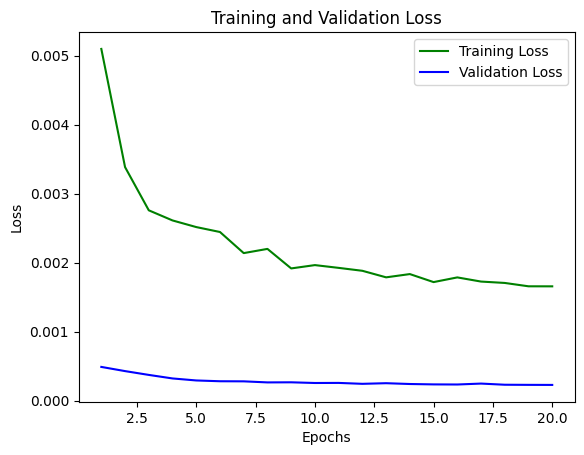

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


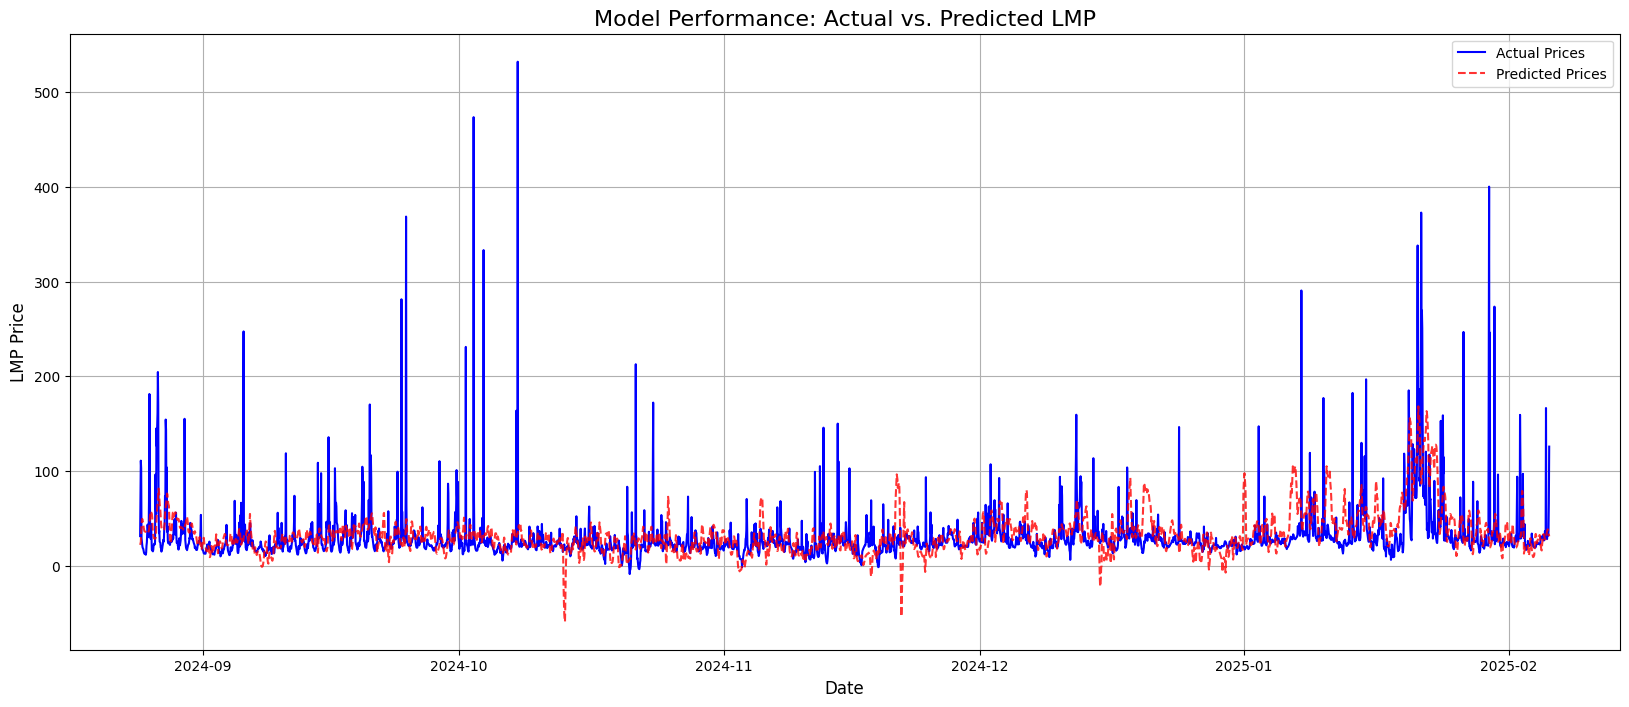

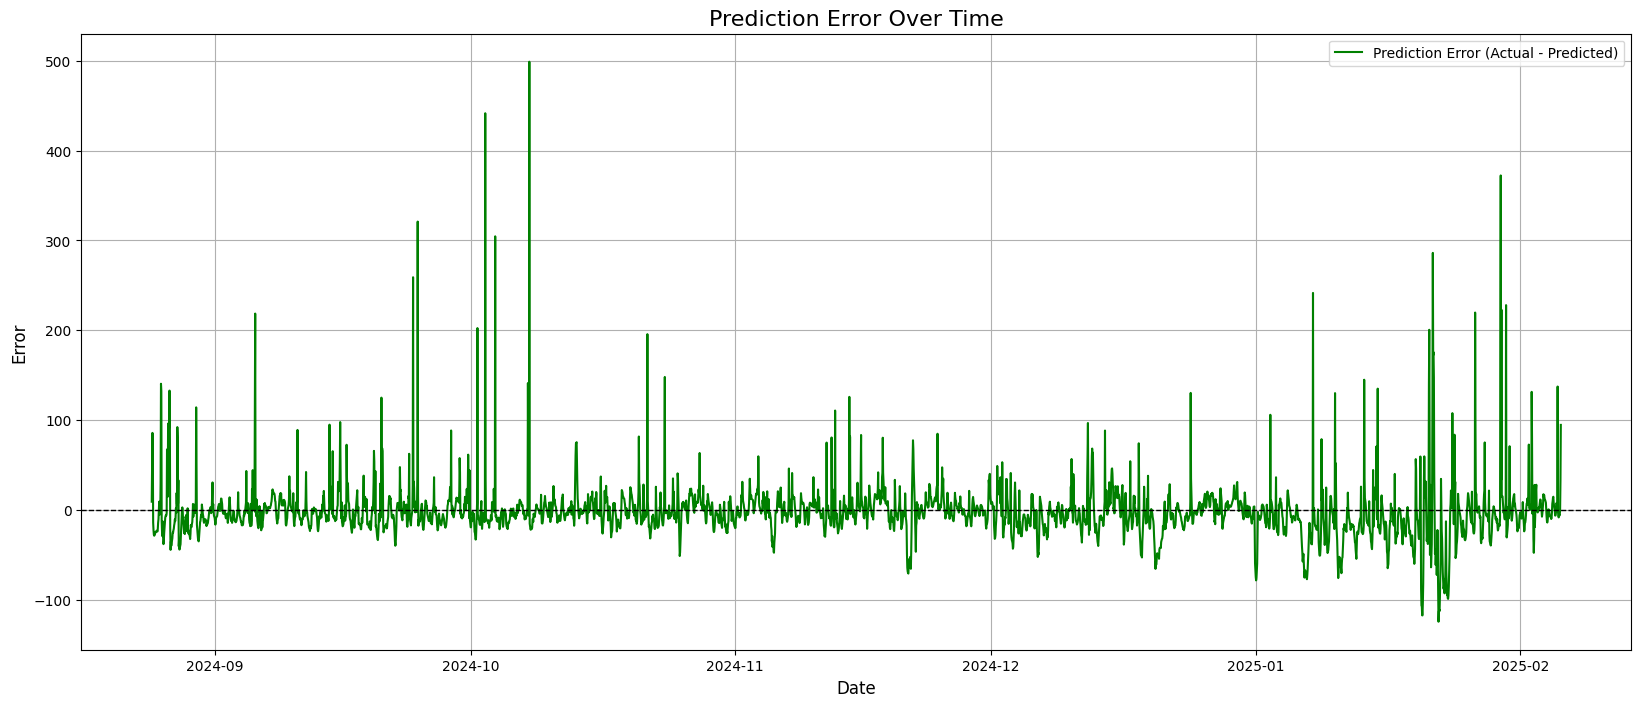

In [ ]:
plot_history(history)
plot_prediction_vs_actual(model)

(Below is scratchpaper code when doing further analysis)

In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Dropout
# import matplotlib.pyplot as plt

# # Load data
# df = pd.read_csv('merged_data4.csv')
# df.drop_duplicates(inplace=True)             # remove duplicate rows
# df.dropna(inplace=True)                      # remove any rows with NaN
# df = df.reset_index(drop=True)

# # Date processing time (make cyclic via sin function)
# df['Date'] = pd.to_datetime(df['Date'])
# df['day_of_week'] = np.sin(2 * np.pi / 7.0 * df['Date'].dt.dayofweek )
# df['hour_of_day'] = np.sin(2 * np.pi / 24.0 * df['Date'].dt.hour)
# df['month'] = np.sin(2 * np.pi / 12.0 * (df['Date'].dt.month - 1))

# # Features and target
# df['AvgPrice_Other_sq'] = df['AveragePrice_OtherStates'] ** 2
# df['AvgPrice_Other_3h'] = df['AveragePrice_OtherStates'].diff(periods=3)
# # fill the NaN values created at the beginning
# df.fillna(0, inplace=True)

# features = [
#     'forecasted_load',
#     'actual_load',
#     'day_ahead_lmp',
#     'AveragePrice_OtherStates',
#     'AvgPrice_Other_sq',
#     'AvgPrice_Other_3h',
#     'day_of_week',
#     'hour_of_day',
#     'month',
#     'wind_speed_kmh',
#     # the following are coco weather reports (0 or 1)
#     'coco_Clear',
#     'coco_Fair',
#     'coco_Cloudy',
#     'coco_Overcast',
#     'coco_Fog',
#     'coco_Light_Rain',
#     'coco_Rain',
#     'coco_Heavy_Rain',
#     'coco_Heavy_Rain_Shower',
#     'coco_Light_Snow',
#     'coco_Snow',
#     'coco_Heavy_Snow',
#     'coco_Thunderstorm',
#     'coco_Sleet',
#     'coco_Heavy_Sleet'
# ]
# target = 'actual_lmp'

# X = df[features].values
# y = df[target].values.reshape(-1, 1)

# # # log scaling
# # old_ymin = np.min(y)
# # y = np.log(y - np.min(y) + 1)

# # Normalize data (important for RNNs)
# scaler_X = MinMaxScaler()
# scaler_y = MinMaxScaler()
# X_scaled = scaler_X.fit_transform(X)
# y_scaled = scaler_y.fit_transform(y)

# # Define sequence length (how many past steps you want to use)
# seq_len = 3  # using past 24 hours - originally 168

# # Create time series sequences
# X_seq, y_seq = [], []
# for i in range(seq_len, len(X_scaled)):
#     X_seq.append(X_scaled[i - seq_len:i])
#     y_seq.append(y_scaled[i])

# X_seq, y_seq = np.array(X_seq), np.array(y_seq)

# # Split into train/evaluation (train will be further split)
# split = int(0.85 * len(X_seq))
# X_train, X_test = X_seq[:split], X_seq[split:]
# y_train, y_test = y_seq[:split], y_seq[split:]

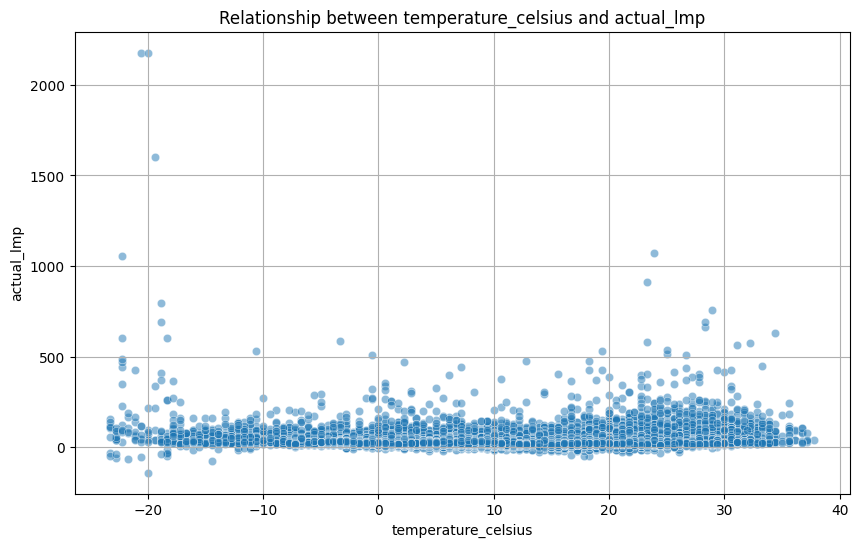

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Assuming 'df' is your pre-processed dataframe
# feature_to_check = 'temperature_celsius'
# target = 'actual_lmp' # Using the original, un-transformed price

# plt.figure(figsize=(10, 6))
# sns.scatterplot(x=df[feature_to_check], y=df[target], alpha=0.5)
# plt.title(f'Relationship between {feature_to_check} and {target}')
# plt.xlabel(feature_to_check)
# plt.ylabel(target)
# plt.grid(True)
# plt.show()

In [ ]:
# from tensorflow.keras.optimizers import Adam, RMSprop, SGD
# import tensorflow.keras.backend as K
# import tensorflow as tf

# # Used AI to help program "custom loss" function
# def weighted_mse(y_true, y_pred):
#     # ~4.86% of labeled data are "outliers" (via IQR method)
#     # also want to include values close to outliers s
#     spike_threshold = 0.90

#     weights = K.cast(K.greater(y_true, spike_threshold), 'float32') * 9.0 + 1.0
#     return K.mean(weights * K.square(y_true - y_pred))


# model2 = Sequential([
#     LSTM(64, activation='tanh', return_sequences=True, input_shape=(seq_len, X_seq.shape[2])),
#     Dropout(0.1),
#     LSTM(32, activation='tanh'),
#     Dropout(0.1),
#     Dense(1)
# ])

# model2.compile(optimizer=Adam(learning_rate=1e-3), loss=weighted_mse)
# history_testing1 = model2.fit(X_train, y_train,epochs=30,batch_size=128,validation_split=0.15,verbose=1)

Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 9.8363e-04 - val_loss: 2.1851e-04
Epoch 2/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0011 - val_loss: 1.9443e-04
Epoch 3/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.0178e-04 - val_loss: 1.9666e-04
Epoch 4/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.0440e-04 - val_loss: 2.1006e-04
Epoch 5/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0011 - val_loss: 2.0920e-04
Epoch 6/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.7312e-04 - val_loss: 2.7274e-04
Epoch 7/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.2002e-04 - val_loss: 2.0797e-04
Epoch 8/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0011 - val_loss: 2.0429e-04
Epoch 9/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.2162e-04 - val_loss: 2.0364e-04
Epoch 10/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.3713e-04 - val_loss: 2.2808e-04
Epoch 11/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.6662e-04 - val_los

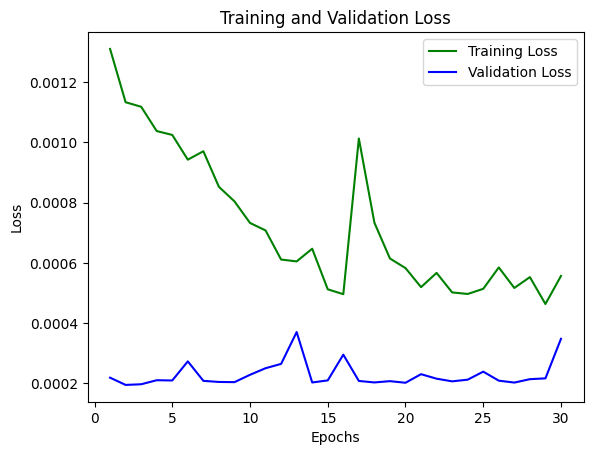

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MAE = 31.008
MSE = 1718.631
RMSE = 41.456
R² = -1.016


In [ ]:
# plot_history(history_testing1)
# print_evaluation(model2)

In [ ]:
# y_pred_scaled = model2.predict(X_test)
# y_pred = scaler_y.inverse_transform(y_pred_scaled)
# y_true = scaler_y.inverse_transform(y_test)

# # y_pred = np.exp(y_pred) + old_ymin - 1
# # y_true = np.exp(y_true) + old_ymin - 1

# y_pred = y_pred.flatten()
# y_true = y_true.flatten()

# mae = mean_absolute_error(y_true, y_pred)
# mse = mean_squared_error(y_true, y_pred)
# rmse = np.sqrt(mse)
# r2 = r2_score(y_true, y_pred)

# print(f"MAE = {mae:.3f}")
# print(f"MSE = {mse:.3f}")
# print(f"RMSE = {rmse:.3f}")
# print(f"R² = {r2:.3f}")

In [ ]:
# """
# lmp_experiments.py

# Full experimental pipeline:
# - Loads merged_data2.csv (assumes same columns as before)
# - Preprocesses features and target
# - Builds sequences for RNN
# - Defines a function to build a stacked LSTM model parametrically
# - Runs experiments over combinations of: batch_size, optimizer, learning_rate, units, dropout, seq_len
# - Uses early stopping and saves best weights per run
# - Evaluates on test set and writes results to results.csv

# Requirements:
# - pandas, numpy, scikit-learn, tensorflow (2.x)
# """

# import os
# import itertools
# import json
# import numpy as np
# import pandas as pd
# from datetime import datetime

# # sklearn
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# from sklearn.model_selection import train_test_split

# # tensorflow / keras
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
# from tensorflow.keras.optimizers import Adam, RMSprop, SGD
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# # ------------ User-editable settings ------------
# DATA_PATH = "merged_data2.csv"
# RESULTS_CSV = "lmp_experiment_results.csv"
# WEIGHTS_DIR = "weights"
# os.makedirs(WEIGHTS_DIR, exist_ok=True)

# # features / target (same as before)
# FEATURES = [
#     'forecasted_load',
#     'actual_load',
#     'day_ahead_lmp',
#     'AveragePrice_OtherStates',
#     'day_of_week',
#     'hour_of_day',
#     'month'
# ]
# TARGET = 'actual_lmp'

# # grid to search (keeps reasonable size; adjust as needed)
# BATCH_SIZES = [16, 32, 64]                # mini-batch experiments
# OPTIMIZERS = ['adam', 'rmsprop', 'sgd']   # optimizers to test
# LEARNING_RATES = [1e-3, 1e-4]             # learning rates (will be applied to optimizer)
# UNITS = [32, 64]                          # LSTM units (first layer)
# DROPOUTS = [0.1, 0.2]                     # dropout rates
# SEQ_LENS = [12, 24]                       # sequence lengths to test (12h, 24h)
# EPOCHS = 50
# PATIENCE = 6

# # random seed for reproducibility
# SEED = 42
# np.random.seed(SEED)
# tf.random.set_seed(SEED)

# # ------------------------------------------------

# def load_and_preprocess(path):
#     df = pd.read_csv(path)
#     df.drop_duplicates(inplace=True)

#     # parse dates
#     df['Date'] = pd.to_datetime(df['Date'])

#     # derive periodic features
#     df['day_of_week'] = df['Date'].dt.dayofweek
#     df['hour_of_day'] = df['Date'].dt.hour
#     df['month'] = df['Date'].dt.month

#     # drop rows with missing values in features/target
#     cols_needed = FEATURES + [TARGET]
#     df = df.dropna(subset=cols_needed).reset_index(drop=True)

#     X = df[FEATURES].values
#     y = df[TARGET].values.reshape(-1, 1)

#     # scale
#     scaler_X = MinMaxScaler().fit(X)
#     scaler_y = MinMaxScaler().fit(y)

#     X_scaled = scaler_X.transform(X)
#     y_scaled = scaler_y.transform(y)

#     return df, X_scaled, y_scaled, scaler_X, scaler_y

# def make_sequences(X_scaled, y_scaled, seq_len):
#     X_seq = []
#     y_seq = []
#     for i in range(seq_len, len(X_scaled)):
#         X_seq.append(X_scaled[i - seq_len:i])
#         y_seq.append(y_scaled[i])
#     X_seq = np.array(X_seq)
#     y_seq = np.array(y_seq)
#     return X_seq, y_seq

# def build_model(input_shape, units=64, dropout=0.2, lr=1e-3, optimizer_name='adam'):
#     model = Sequential()
#     # stacked LSTM
#     model.add(LSTM(units, return_sequences=True, input_shape=input_shape))
#     model.add(BatchNormalization())
#     model.add(Dropout(dropout))

#     model.add(LSTM(int(units/2)))
#     model.add(BatchNormalization())
#     model.add(Dropout(dropout))

#     model.add(Dense(32, activation='relu'))
#     model.add(Dense(1, activation='linear'))

#     # optimizer selection
#     if optimizer_name.lower() == 'adam':
#         opt = Adam(learning_rate=lr)
#     elif optimizer_name.lower() == 'rmsprop':
#         opt = RMSprop(learning_rate=lr)
#     elif optimizer_name.lower() == 'sgd':
#         opt = SGD(learning_rate=lr, momentum=0.9)
#     else:
#         raise ValueError(f"Unknown optimizer {optimizer_name}")

#     model.compile(optimizer=opt, loss='mse', metrics=['mae'])
#     return model

# def evaluate_and_log(y_true, y_pred):
#     y_true = y_true.reshape(-1, 1)
#     y_pred = y_pred.reshape(-1, 1)
#     mae = mean_absolute_error(y_true, y_pred)
#     rmse = np.sqrt(mean_squared_error(y_true, y_pred))
#     r2 = r2_score(y_true, y_pred)
#     return mae, rmse, r2

# def main():
#     print("Loading and preprocessing data...")
#     df, X_scaled, y_scaled, scaler_X, scaler_y = load_and_preprocess(DATA_PATH)

#     # Split indices for train/test/val on the original series BEFORE making sequences to avoid leakage.
#     # We'll first create sequences and then do a chronological split: train (70%), val (15%), test (15%)
#     overall_results = []

#     for seq_len, units, dropout, batch_size, opt_name, lr in itertools.product(
#         SEQ_LENS, UNITS, DROPOUTS, BATCH_SIZES, OPTIMIZERS, LEARNING_RATES
#     ):
#         run_id = f"seq{seq_len}_u{units}_d{int(dropout*100)}_b{batch_size}_{opt_name}_lr{lr}"
#         print("\n" + "="*60)
#         print(f"RUN: {run_id}  ({datetime.now().isoformat()})")
#         print("="*60)

#         # 1) Make sequences
#         X_seq, y_seq = make_sequences(X_scaled, y_scaled, seq_len)

#         # 2) Chronological split (no shuffling) into train/val/test
#         N = len(X_seq)
#         train_end = int(0.7 * N)
#         val_end = int(0.85 * N)

#         X_train = X_seq[:train_end]
#         y_train = y_seq[:train_end]
#         X_val = X_seq[train_end:val_end]
#         y_val = y_seq[train_end:val_end]
#         X_test = X_seq[val_end:]
#         y_test = y_seq[val_end:]

#         print(f"Sequence length: {seq_len}, total samples: {N}")
#         print(f"Train/Val/Test sizes: {len(X_train)}, {len(X_val)}, {len(X_test)}")

#         # 3) Build model
#         model = build_model(input_shape=(seq_len, X_seq.shape[2]), units=units, dropout=dropout, lr=lr, optimizer_name=opt_name)

#         # callbacks
#         weights_path = os.path.join(WEIGHTS_DIR, f"{run_id}.h5")
#         es = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True, verbose=1)
#         cp = ModelCheckpoint(weights_path, monitor='val_loss', save_best_only=True, verbose=0)
#         reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=0)

#         # 4) Fit model (we'll use validation data explicitly)
#         history = model.fit(
#             X_train, y_train,
#             validation_data=(X_val, y_val),
#             epochs=EPOCHS,
#             batch_size=batch_size,
#             callbacks=[es, cp, reduce_lr],
#             verbose=1
#         )

#         # 5) Evaluate on test set
#         y_pred_scaled = model.predict(X_test)
#         y_pred = scaler_y.inverse_transform(y_pred_scaled)
#         y_true = scaler_y.inverse_transform(y_test)

#         mae, rmse, r2 = evaluate_and_log(y_true, y_pred)

#         print(f"Test MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")

#         # log run
#         run_result = {
#             "run_id": run_id,
#             "seq_len": seq_len,
#             "units": units,
#             "dropout": dropout,
#             "batch_size": batch_size,
#             "optimizer": opt_name,
#             "learning_rate": lr,
#             "train_samples": len(X_train),
#             "val_samples": len(X_val),
#             "test_samples": len(X_test),
#             "test_mae": float(mae),
#             "test_rmse": float(rmse),
#             "test_r2": float(r2),
#             "best_epoch": int(np.argmin(history.history['val_loss'])) if 'val_loss' in history.history else None,
#             "train_val_loss_first_epoch": float(history.history['loss'][0]) if len(history.history['loss'])>0 else None,
#             "train_val_loss_last_epoch": float(history.history['loss'][-1]) if len(history.history['loss'])>0 else None
#         }
#         overall_results.append(run_result)

#         # optionally save a small json of history for deeper analysis
#         hist_path = os.path.join(WEIGHTS_DIR, f"{run_id}_history.json")
#         with open(hist_path, "w") as f:
#             json.dump(history.history, f)

#     # save results to csv
#     results_df = pd.DataFrame(overall_results)
#     results_df.to_csv(RESULTS_CSV, index=False)
#     print(f"\nAll experiments complete. Results saved to {RESULTS_CSV}")
#     print(f"Weights and history saved under {WEIGHTS_DIR}/")

# if __name__ == "__main__":
#     main()
